In [1]:
import sys
import pickle
import numpy as np
import tensorflow as tf
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path to directory containing code of this case

In [2]:
new_path = r'/home/users/suihong/5-karstcave3D_Complete_cond_well_globalfeatures_probmap_Upload/' 
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = '/scratch/users/suihong/CaveSimulation/DatasetsforGAN_ave_3D/'

#### Set path to trained network

In [4]:
network_dir = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/110-pgan3D-4gpu-V100-OnlyCV-LC_8-GANw_2-NoLabelCond-CondWell_0.7-Enlarg-CondProb_1/'
network_name = 'network-snapshot-003360.pkl'

### 1. Fetch test dataset

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', labeltypes = [], well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Fetch 30 pairs of dataset
# labels are from -1 to 1
realcubes_test, labels_test = test_set.get_minibatch_cubeandlabel_np(30)  
probcubes_test, wellfaciescubes_test = test_set.get_minibatch_probandwell_np(30)
realcubes_test = realcubes_test/255


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64, 64]
Dynamic range = [0, 255]
Label size    = 0


In [6]:
print(realcubes_test.shape)
print(labels_test.shape)
print(probcubes_test.shape)
print(wellfaciescubes_test.shape)

(30, 1, 64, 64, 64)
(30, 0)
(30, 1, 64, 64, 64)
(30, 1, 64, 64, 64)


### 2. Import pre-trained Network

In [7]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import networks.
with open(network_dir+network_name, 'rb') as file:
    G, D, Gs = pickle.load(file)
    
del G

/share/software/user/open/py-tensorflow/1.12.0_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 3. Evaluation on 64x64x64 synthetic cases

#### 3.1 Synthetic case 1

##### (1) Get synthetic karst cave model (groundtruth model; i.e., the 1st model in test_set) 

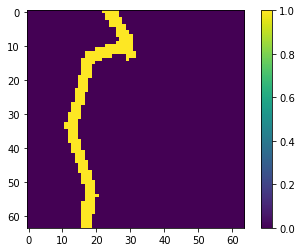

In [8]:
synmodel2 = realcubes_test[1:2]
plt.imshow(synmodel2[0,0,:,:,30])
plt.colorbar()

##### (2) Get probability cube

In [9]:
###### 3D Frequency map calculated from 400 generated facies models

def addnoiseforres64(cube):
    cube_noise = cube
    
    # (1) add noise within cave facies    
    if np.round(np.sum(cube)/200)>0:
        cave_indices = np.argwhere(cube>=0.9)
        cavenoisenumber = np.random.randint(0, np.round(np.sum(cube)/1200))
        cave_noise_indices = np.random.randint(0, cave_indices.shape[0], cavenoisenumber)    
        cave_noise_coos = cave_indices[cave_noise_indices]
        cube_noise[cave_noise_coos[:, 0], cave_noise_coos[:, 1], cave_noise_coos[:, 2]] = (np.random.rand(cavenoisenumber) * 300+10) * (-1)
   
    # (2) add noise within non-cave facies
    noncavenoisenumber = np.random.randint(1, np.round((64*64*64 - np.sum(cube))/8000))
    noncave_indices = np.argwhere(cube<=0.1)
    noncave_noise_indices = np.random.randint(0, noncave_indices.shape[0], noncavenoisenumber)
    noncave_noise_coos = noncave_indices[noncave_noise_indices]
    cube_noise[noncave_noise_coos[:, 0], noncave_noise_coos[:, 1], noncave_noise_coos[:,2]] = np.random.rand(noncavenoisenumber) * 600
    
    return cube_noise

from scipy import ndimage
def calcprobcubeforres64(faciesmodel): #facies model with the dimension of [n, 0, 64, 64, 64]
    probcube = np.zeros((1, 1, 64, 64, 64), dtype=np.float32) 
    k = 6 # kernel size    np.random.choice([4, 6, 8, 10])
    faciesmodel_withnoise = faciesmodel[0,0] #addnoiseforres64(faciesmodel[0,0])
    padvalue = np.mean(faciesmodel_withnoise)
    prob_cube = ndimage.gaussian_filter(faciesmodel_withnoise, (k, k, 3*k), mode = 'constant', cval = padvalue) 
    if np.amax(prob_cube, axis = (0,1,2))<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.rand(1)*0.75+0.25
        prob_cube = (prob_cube - np.amin(prob_cube, axis = (0,1,2))) * prob_mx/(np.amax(prob_cube, axis = (0,1,2)) - np.amin(prob_cube, axis = (0,1,2)))
    prob_cube = np.where(prob_cube>0.9, 0.9, prob_cube)
    prob_cube = np.where(prob_cube<0.02, 0.02, prob_cube) 
    probcube[0, 0] = prob_cube 
    return probcube

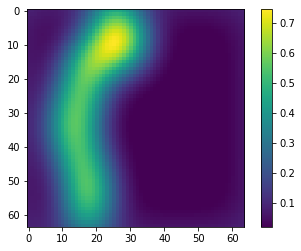

In [10]:
synprob2 = calcprobcubeforres64(synmodel2)
plt.imshow(synprob2[0,0,:,:,30].astype(np.float))
plt.colorbar()

##### (3) Sample well facies from the groundtruth model

In [11]:
def samplewells(cube, cavewellnumber, noncavewellnumber):
    wellfacies = np.ones(cube.shape)*(-99)
    cave_indices = np.argwhere(cube>=0.9)
    cave_wells_indices = np.random.RandomState(16).randint(0, cave_indices.shape[0], cavewellnumber) 
    cave_wells_coos = cave_indices[cave_wells_indices]
    wellfacies[0,0,cave_wells_coos[:, 2], cave_wells_coos[:, 3], :] = cube[0,0,cave_wells_coos[:, 2], cave_wells_coos[:, 3], :]

    noncave_indices = np.argwhere(cube<=0.1)
    noncave_wells_indices = np.random.RandomState(51838).randint(0, noncave_indices.shape[0], noncavewellnumber) 
    noncave_wells_coos = noncave_indices[noncave_wells_indices]
    wellfacies[0,0,noncave_wells_coos[:, 2], noncave_wells_coos[:, 3], :] = cube[0,0,noncave_wells_coos[:, 2], noncave_wells_coos[:, 3], :]

    return wellfacies

In [12]:
synwellfacies2 = samplewells(synmodel2, 2, 2)

In [13]:
syn_wellpoints2 = np.where(synwellfacies2 == -99, 0, 1)
syn_welltypes2 = np.where(synwellfacies2 == -99, 0, synwellfacies2)
syn_wellfacies_input2 = np.concatenate([syn_wellpoints2, syn_welltypes2], 1)      
print(syn_wellfacies_input2.shape)

(1, 2, 64, 64, 64)


In [14]:
### Enlarge areas of well points into 4 x 4 as inputs

syn_wellfacies_input2 = syn_wellfacies_input2.astype(np.float32)
with tf.device('/gpu:0'):
    syn_wellfacies_input2_enlarge = tf.nn.max_pool3d(syn_wellfacies_input2, ksize = [1,1,4,4,4], strides=[1,1,1,1,1], padding='SAME', data_format='NCDHW') 

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    syn_wellfacies_input2_el = sess.run(syn_wellfacies_input2_enlarge)

# make mask of output well facies data 
syn_wellfacies_input2_el_onechannel = syn_wellfacies_input2_el[:,0:1]+syn_wellfacies_input2_el[:,1:2]
syn_wellfacies_input2_el_onechannel_mask = np.ma.masked_where(syn_wellfacies_input2_el_onechannel == 0, syn_wellfacies_input2_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

In [15]:
print(syn_wellfacies_input2_el.shape)

(1, 2, 64, 64, 64)


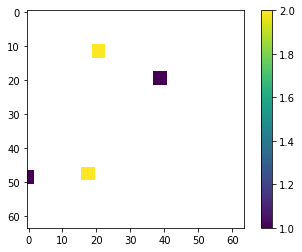

In [16]:
plt.imshow(syn_wellfacies_input2_el_onechannel_mask[0,0,:,:,30])
plt.colorbar()

##### (4) Generate cave models using trained generator

In [17]:
print(Gs.input_shapes)

[[None, 8, 4, 4, 4], [None, 0, 4, 4, 4], [None, 2, 64, 64, 64], [None, 1, 64, 64, 64]]


In [18]:
print(synmodel2.shape)
print(synprob2.shape)
print(syn_wellfacies_input2_el.shape)

(1, 1, 64, 64, 64)
(1, 1, 64, 64, 64)
(1, 2, 64, 64, 64)


In [19]:
TotalReal_no = 400
condfakemodels = np.zeros([TotalReal_no, 1, 64, 64, 64])
latents = np.random.RandomState(79315).randn(TotalReal_no, 8, 4, 4, 4)
for i in range(int(TotalReal_no/10)):
    latents2 = latents[i*10:(i+1)*10]
    labels2 = np.random.randn(10, 0, 4, 4, 4)  #.RandomState(816)
    syn_wellfacies_input2_el_mult = np.repeat(syn_wellfacies_input2_el, 10, axis=0)
    synprob2_mult = np.repeat(synprob2, 10, axis=0)   
    fakemodels = Gs.run(latents2, labels2, syn_wellfacies_input2_el_mult, synprob2_mult)
    fakemodels = np.where(fakemodels< 0, -1, 1)
    condfakemodels[i*10:(i+1)*10] = fakemodels

In [20]:
print(condfakemodels.shape)

(400, 1, 64, 64, 64)


In [25]:
TotalReal_no = 400
scores = np.zeros(TotalReal_no)
for i in range(int(TotalReal_no/4)):
    scores[i*4:(i+1)*4] = D.run(condfakemodels[i*4:(i+1)*4])[0][:,0]
    
score_ind = np.argsort(scores)

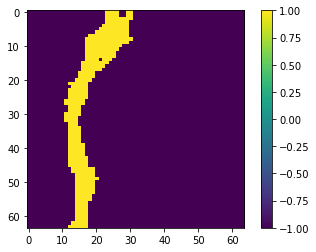

In [26]:
plt.imshow(condfakemodels[score_ind[-8],0,:,:,30])
plt.colorbar()

In [27]:
condfakemodels_freqmap = np.expand_dims(np.average((condfakemodels + 1)/2, axis = 0), axis = 0)

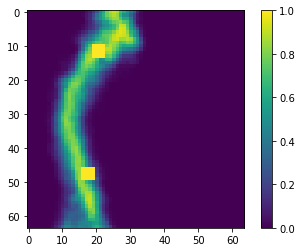

In [28]:
plt.imshow(condfakemodels_freqmap[0,0,:,:,30])
plt.colorbar()

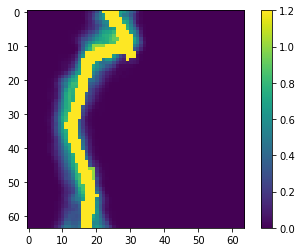

In [29]:
groundtru_overlap_freqmap = np.where(synmodel2 == 1, 1.2, condfakemodels_freqmap)
plt.imshow(groundtru_overlap_freqmap[0,0,:,:,30])
plt.colorbar()

##### (5) Calculate "IOU" distance/similarity between ground truth and generated facies models 

In [30]:
# 1) Calculate cave volume of ground truth facies model (real model)
r_v = np.sum(synmodel2)

# 2) Calculate cave volumes of generated facies models (fake model)
f_v = np.sum(np.where(condfakemodels==1,1,0), axis = (1,2,3,4))

# 3) Calculate cave intersection of groundtruth and generated facies models
i_v = np.sum(np.where((condfakemodels + synmodel2)==2,1,0), axis = (1,2,3,4))

# 4) Calculate IOU (Cave intersection/Cave Union of groundtruth and generated facies models)
IOU = i_v/(r_v + f_v - i_v)

In [31]:
# labels are from -1 to 1
realcubes_test_400, _ = test_set.get_minibatch_cubeandlabel_np(410)  
realcubes_test_400 = realcubes_test_400/255
realcubes_test_400 = realcubes_test_400[10:]

In [32]:
# 2) Calculate cave volumes of generated facies models (fake model)
f_v_test_400 = np.sum(realcubes_test_400, axis = (1,2,3,4))

# 3) Calculate cave intersection of groundtruth and generated facies models
i_v_test_400 = np.sum(np.where((realcubes_test_400 + synmodel2)==2,1,0), axis = (1,2,3,4))

# 4) Calculate IOU (Cave intersection/Cave Union of groundtruth and generated facies models)
IOU_test_400 = i_v_test_400/(r_v + f_v_test_400 - i_v_test_400)

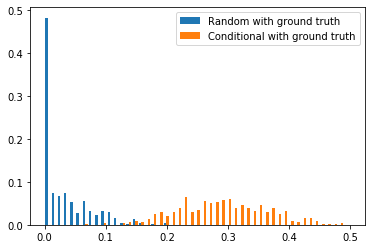

In [39]:
fig, ax = plt.subplots()

w = np.empty(400)
w.fill(1/400)
bins = np.linspace(0, 0.5, 50)

ax.hist([IOU_test_400, IOU], bins, weights=[w, w], label=['Random with ground truth', 'Conditional with ground truth'])
ax.legend(loc='upper right')

save_path = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/IOU histogram.png'
plt.savefig(save_path, dpi=200) 

In [40]:
# Produce facies model realizations as examples when IOU = 0.2

IOU_point2_number = np.argwhere((IOU>0.18) & (IOU<0.22))
scores_point2 = scores[IOU_point2_number]

print(np.concatenate((IOU_point2_number,scores_point2), axis = 1 ))

[[  12.         -138.76615906]
 [  19.         -108.0528717 ]
 [  31.          -91.83430481]
 [  33.          -57.78588104]
 [  36.          -85.94863129]
 [  40.         -113.95960999]
 [  45.          -92.17934418]
 [  52.          -66.28742981]
 [  54.          -55.24633789]
 [  55.         -100.01835632]
 [  95.         -144.36639404]
 [  97.          -81.82495117]
 [ 124.         -134.2494812 ]
 [ 128.         -300.89105225]
 [ 132.         -190.0894928 ]
 [ 162.          -82.70122528]
 [ 171.         -106.11154938]
 [ 184.          -55.71463013]
 [ 202.         -117.88393402]
 [ 206.          -48.76512146]
 [ 209.          -88.6554718 ]
 [ 223.          -86.48256683]
 [ 224.         -102.52166748]
 [ 236.         -163.56077576]
 [ 245.          -43.62789536]
 [ 257.         -104.46038818]
 [ 267.         -101.17541504]
 [ 270.         -114.83722687]
 [ 272.          -49.98248291]
 [ 274.         -148.41505432]
 [ 276.          -91.72826385]
 [ 288.          -81.34024811]
 [ 304. 

In [41]:
onecube = np.zeros([realcubes_test.shape[4],realcubes_test.shape[2],realcubes_test.shape[3]])
print(onecube.shape)
coords = np.argwhere(onecube>-1)
print(coords.shape)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = realcubes_test.shape[4] - coords[:,0]
coords_output = coords_output.astype(np.int8)

(64, 64, 64)
(262144, 3)


In [42]:
numb = [245,380,371,54]
best4models = condfakemodels[numb]
print(best4models.shape)
best4models_output = best4models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best4models_output = np.where(best4models_output>0,1,-99)
best4models_output_txt = np.concatenate((coords_output, best4models_output), axis = 1)
print(best4models_output_txt.shape)

(4, 1, 64, 64, 64)
(262144, 7)


In [43]:
best4models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/IOU_point2_best4_models.txt'
np.savetxt(best4models_fname, best4models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

In [44]:
# Produce facies model realizations as examples when IOU = 0.3

IOU_point3_number = np.argwhere((IOU>0.29) & (IOU<0.31))
scores_point3 = scores[IOU_point3_number]

print(np.concatenate((IOU_point3_number,scores_point3), axis = 1 ))

[[  13.          -97.85229492]
 [  15.          -74.42617798]
 [  23.         -125.96347046]
 [  24.          -84.48041534]
 [  28.          -77.83901978]
 [  46.         -128.86836243]
 [  62.          -85.27702332]
 [  74.         -105.13791656]
 [  75.          -96.11339569]
 [  77.          -97.09792328]
 [  86.          -59.72945404]
 [  91.          -93.32948303]
 [ 108.          -82.53954315]
 [ 158.          -70.63625336]
 [ 161.         -161.46813965]
 [ 167.          -78.21716309]
 [ 173.         -106.3924408 ]
 [ 188.         -122.42660522]
 [ 192.         -105.18341827]
 [ 197.          -82.33116913]
 [ 200.          -93.72246552]
 [ 213.         -185.55528259]
 [ 225.          -89.03305817]
 [ 229.          -80.84851837]
 [ 239.         -153.38687134]
 [ 242.          -65.11650085]
 [ 250.         -124.6877594 ]
 [ 275.         -226.260849  ]
 [ 278.          -73.83567047]
 [ 290.          -59.1528244 ]
 [ 305.         -240.79626465]
 [ 313.          -87.65448761]
 [ 314. 

In [45]:
numb = [109, 86, 242, 285]
best4models = condfakemodels[numb]
print(best4models.shape)
best4models_output = best4models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best4models_output = np.where(best4models_output>0,1,-99)
best4models_output_txt = np.concatenate((coords_output, best4models_output), axis = 1)
print(best4models_output_txt.shape)

(4, 1, 64, 64, 64)
(262144, 7)


In [46]:
best4models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/IOU_point3_best4_models.txt'
np.savetxt(best4models_fname, best4models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

In [47]:
# Produce facies model realizations as examples when IOU = 0.4

IOU_point4_number = np.argwhere((IOU>0.38) & (IOU<0.42))
scores_point4 = scores[IOU_point4_number]

print(np.concatenate((IOU_point4_number,scores_point4), axis = 1 ))

[[   9.         -147.30340576]
 [  10.          -77.84176636]
 [  11.         -100.26435852]
 [  29.          -49.85438538]
 [  70.          -84.87057495]
 [  87.          -73.28369141]
 [  89.          -63.81481171]
 [ 101.         -110.06735229]
 [ 126.         -121.22185516]
 [ 129.          -87.6491394 ]
 [ 143.          -88.04206085]
 [ 164.         -109.96668243]
 [ 172.         -139.18382263]
 [ 196.         -113.21440887]
 [ 207.          -67.37117767]
 [ 211.          -75.85119629]
 [ 237.          -53.44446564]
 [ 251.          -85.00554657]
 [ 253.         -104.99826813]
 [ 258.          -79.80265808]
 [ 302.          -90.79746246]
 [ 311.          -79.10947418]
 [ 328.          -59.92642975]
 [ 339.          -86.20556641]
 [ 345.          -84.54781342]
 [ 359.          -79.45545197]
 [ 389.          -60.7769928 ]
 [ 395.         -100.98193359]]


In [48]:
numb = [3, 195, 237, 243]
best4models = condfakemodels[numb]
print(best4models.shape)
best4models_output = best4models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best4models_output = np.where(best4models_output>0,1,-99)
best4models_output_txt = np.concatenate((coords_output, best4models_output), axis = 1)
print(best4models_output_txt.shape)

(4, 1, 64, 64, 64)
(262144, 7)


In [49]:
best4models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/IOU_point4_best4_models.txt'
np.savetxt(best4models_fname, best4models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

##### (6) Make Multiscale-pyramid-sliced Wasserstein based MDS plot

In [50]:
def pyr_down(model): # matches cv2.pyrDown()
    assert model.ndim == 4
    return np.expand_dims(scipy.ndimage.gaussian_filter(model[0], (2, 2, 2), mode='mirror')[::2,::2, ::2], axis = 0)

def pyr_up(minibatch): # matches cv2.pyrUp()
    assert minibatch.ndim == 4
    S = minibatch.shape
    res = np.zeros((S[0], S[1] * 2, S[2] * 2, S[3] * 2), minibatch.dtype)
    res[:, ::2, ::2, ::2] = minibatch
    return np.expand_dims(scipy.ndimage.gaussian_filter(res[0], (2, 2, 2), mode='mirror') * 8, axis = 0) 

def generate_laplacian_pyramid(model, num_levels):  # model with shape of [1,64,64,64],num_levels = 3
    pyramid = [np.float32(model)]
    for i in range(1, num_levels):
        pyramid.append(pyr_down(pyramid[-1]))
        pyramid[-2] -= pyr_up(pyramid[-1])
    return pyramid

def get_descriptors_for_minibatch(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, length, width, height)  [1, 64, 64, 64]
    assert len(S) == 4 
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, x, y, z = np.ogrid[0:N,-H:H+1, -H:H+1, -H:H+1]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[1] - H, size=(N, 1, 1, 1))
    y = y + np.random.randint(H, S[2] - H, size=(N, 1, 1, 1))
    z = z + np.random.randint(H, S[3] - H, size=(N, 1, 1, 1))
    idx = ((img * S[1] + x) * S[2] + y) * S[3] + z
    return minibatch.flat[idx]

def finalize_descriptors(desc):
    if isinstance(desc, list):
        desc = np.concatenate(desc, axis=0)
    assert desc.ndim == 4 # (neighborhood, length, width, height)
    desc -= np.mean(desc, axis=(0, 1, 2, 3), keepdims=True)
    desc /= np.std(desc, axis=(0, 1, 2, 3), keepdims=True)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def sliced_wasserstein(A, B, dir_repeats, dirs_per_repeat):
    assert A.ndim == 2 and A.shape == B.shape                           # (neighborhood, descriptor_component)
    results = []
    for repeat in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)             # (descriptor_component, direction)
        dirs /= np.sqrt(np.sum(np.square(dirs), axis=0, keepdims=True)) # normalize descriptor components for each direction
        dirs = dirs.astype(np.float32)
        projA = np.matmul(A, dirs)                                      # (neighborhood, direction)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)                                  # sort neighborhood projections for each direction
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)                                   # pointwise wasserstein distances
        results.append(np.mean(dists))                                  # average over neighborhoods and directions
    return np.mean(results)                                             # average over repeats

In [51]:
# realcubes_test_400:  400 test facies models,  (400, 1, 64, 64, 64), 0 to 1
# condfakemodels:  400 produced conditional facies models,  (400, 1, 64, 64, 64), -1 to 1
# synmodel2:  original test ground truth facies model,  (1, 1, 64, 64, 64), 0 to 1

from scipy import signal
from scipy.ndimage.filters import convolve
from sklearn import manifold
from matplotlib import pyplot as plt
from scipy.stats import kde
import scipy.ndimage

# MDS map for 200 test facies models, 50 produced facies models, and 1 ground truth facies models orderly
test_mds_num = 100
prod_mds_num = 40
testmodels_mds = realcubes_test_400[300:300+test_mds_num]
prodmodels_mds = (condfakemodels[score_ind[-(prod_mds_num+1):-1]]+1)/2
allmodels_mds = np.squeeze(np.concatenate((testmodels_mds, prodmodels_mds,synmodel2), axis = 0))  # shape [251, 64, 64, 64]

nhood_size         = 5   # neighborhood size, 5x5x5
nhoods_per_cube   = 24   
dir_repeats        = 4
dirs_per_repeat    = 32
resolutions = [64, 32, 16]  # pyramid resolutions 

groups_lap = []
for i in range(test_mds_num+prod_mds_num+1):
    descriptors = [[] for res in resolutions]
    for lod, level in enumerate(generate_laplacian_pyramid(allmodels_mds[i:i+1], len(resolutions))):
        desc = get_descriptors_for_minibatch(level, nhood_size, nhoods_per_cube)
        descriptors[lod].append(desc)
    groups_lap.append(descriptors)

In [52]:
kk = np.tril(np.ones((test_mds_num+prod_mds_num+1,test_mds_num+prod_mds_num+1)), -1)  
coor = np.argwhere(kk > 0)
list_1 = coor[:, 0]
list_2 = coor[:, 1]  
        
gr_swd = []
for gr in range(list_1.shape[0]):
    desc_1 = [finalize_descriptors(d) for d in groups_lap[list_1[gr]]]
    desc_2 = [finalize_descriptors(d) for d in groups_lap[list_2[gr]]]
    slw = [sliced_wasserstein(dreal, dfake, dir_repeats, dirs_per_repeat) for dreal, dfake in zip(desc_1, desc_2)]
    gr_swd.append(np.mean(slw))
        
def convert_to_matrix(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1) # or np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n),dtype=float)
    out[mask] = a
    np.transpose(out)[mask] = a        
    return out        

swd_matrix = convert_to_matrix(gr_swd)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'label'
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'label'


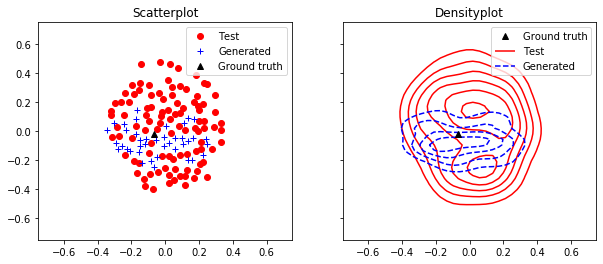

In [58]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
coos = mds.fit(swd_matrix).embedding_
        
x_test_co = coos[:test_mds_num, 0]
y_test_co = coos[:test_mds_num, 1]
x_produced_co = coos[test_mds_num:test_mds_num+prod_mds_num, 0]
y_produced_co = coos[test_mds_num:test_mds_num+prod_mds_num, 1]  
x_groundtruth_co = coos[test_mds_num+prod_mds_num:, 0]
y_groundtruth_co = coos[test_mds_num+prod_mds_num:, 1] 
        
plot_lim_min = -0.75
plot_lim_max = 0.75

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, sharey='row')
fig.set_size_inches(10, 4, forward=True)
        
axes[0].set_title('Scatterplot')
axes[0].set_xlim([plot_lim_min, plot_lim_max])
axes[0].set_ylim([plot_lim_min, plot_lim_max])        
axes[0].plot(x_test_co, y_test_co, 'ro', label = 'Test')
axes[0].plot(x_produced_co, y_produced_co, 'b+', label = 'Generated')
axes[0].plot(x_groundtruth_co, y_groundtruth_co, 'k^', label = 'Ground truth')
axes[0].legend(loc='upper right')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 40
k_test = kde.gaussian_kde((coos.T[:, :test_mds_num]))
xi_test, yi_test = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))
axes[1].set_xlim([plot_lim_min, plot_lim_max])
axes[1].set_ylim([plot_lim_min, plot_lim_max])                
test_contr = axes[1].contour(xi_test, yi_test, zi_test.reshape(xi_test.shape), 6, colors='r', label = 'Test') 

k_produced = kde.gaussian_kde((coos.T[:, test_mds_num:test_mds_num+prod_mds_num]))
xi_produced, yi_produced = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_produced = k_produced(np.vstack([xi_produced.flatten(), yi_produced.flatten()]))
produced_contr = axes[1].contour(xi_produced, yi_produced, zi_produced.reshape(xi_produced.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated') 
        
test_contr.collections[0].set_label('Test')
produced_contr.collections[0].set_label('Generated')

axes[1].plot(x_groundtruth_co, y_groundtruth_co, 'k^', label = 'Ground truth')
        
axes[1].set_title('Densityplot')

axes[1].legend(loc='upper right') 
        
plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/features_MDS_plot.png' , dpi=200)


##### (7) Make input probabilitymap-frequency map-ground truth comparison plot

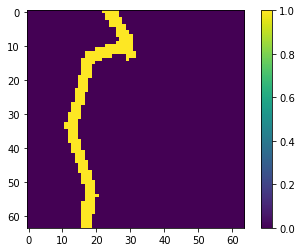

In [54]:
synmodel2 = realcubes_test[1:2]
plt.imshow(synmodel2[0,0,:,:,30])
plt.colorbar()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  from ipykernel import kernelapp as app
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'label'


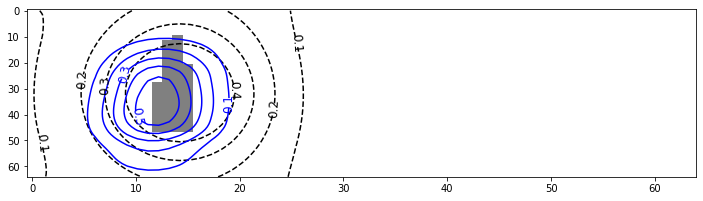

In [55]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl 

# at y = 30

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (12,10))

y, x = np.mgrid[0:64:64j, 0:64:64j]

synmodel2_plt = synmodel2[0,0,30,:,:]
colors = ['white', 'grey'] 
cmap = mpl.colors.ListedColormap(colors)
axes.imshow(synmodel2_plt.transpose(1,0)[::-1,:], cmap = cmap, aspect = 0.25)

inprob_contr = axes.contour(y, x, synprob2[0,0,30,:,::-1], [0.1, 0.2, 0.3, 0.4], colors='k', linestyles= 'dashed', label = 'Probability map contour') 
plt.clabel(inprob_contr,fmt='%1.1f', inline=True, fontsize=12)

z = gaussian_filter(condfakemodels_freqmap[0,0,30,:,::-1], sigma = 2.5)
freq_contr = axes.contour(y, x, z, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='blue', label = 'Frequency map contour') 
plt.clabel(freq_contr,[0.1,0.3, 0.5, 0.7], fmt='%1.1f', inline=True, fontsize=12)

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/Prob_freq_Compar_y30.png' , dpi=200)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  app.launch_new_instance()


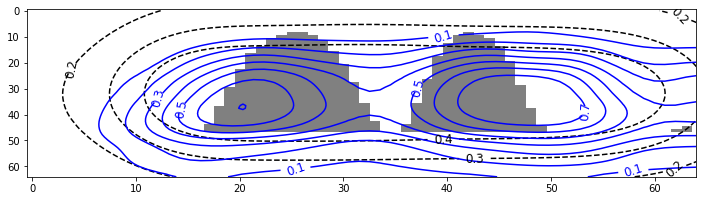

In [56]:
# at x =15

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (12,10))

y, x = np.mgrid[0:64:64j, 0:64:64j]

synmodel2_plt = synmodel2[0,0,:,15,:]
colors = ['white', 'grey'] 
cmap = mpl.colors.ListedColormap(colors)
axes.imshow(synmodel2_plt.transpose(1,0)[::-1,:], cmap = cmap, aspect = 0.25)

inprob_contr = axes.contour(y, x, synprob2[0,0,:,15,::-1], [0.1, 0.2, 0.3, 0.4], colors='k', linestyles= 'dashed', label = 'Probability map contour') 
plt.clabel(inprob_contr,fmt='%1.1f', inline=True, fontsize=12)

z = gaussian_filter(condfakemodels_freqmap[0,0,:,15,::-1], sigma = 2.5)
freq_contr = axes.contour(y, x, z, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='blue', label = 'Frequency map contour') 
plt.clabel(freq_contr,[0.1,0.3, 0.5, 0.7], fmt='%1.1f', inline=True, fontsize=12)

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/Prob_freq_Compar_x15.png' , dpi=200)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  app.launch_new_instance()


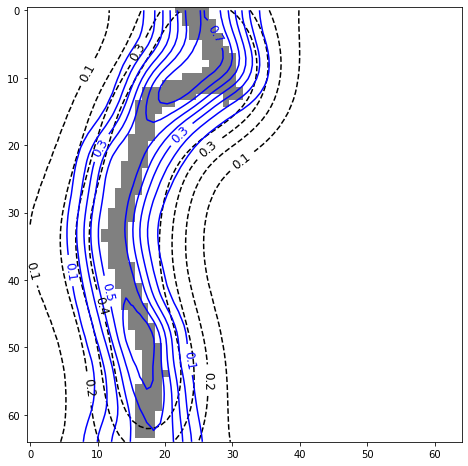

In [57]:
# at z =30

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (8,8))

y, x = np.mgrid[0:64:64j, 0:64:64j]

synmodel2_plt = synmodel2[0,0,:,:,30]
colors = ['white', 'grey'] 
cmap = mpl.colors.ListedColormap(colors)
axes.imshow(synmodel2_plt, cmap = cmap, aspect = 1)

inprob_contr = axes.contour(x, y, synprob2[0,0,:,:,30], [0.1, 0.2, 0.3, 0.4], colors='k', linestyles= 'dashed', label = 'Probability map contour') 
plt.clabel(inprob_contr,fmt='%1.1f', inline=True, fontsize=12)

z = gaussian_filter(condfakemodels_freqmap[0,0,:,:,30], sigma = 2.5)
freq_contr = axes.contour(x, y, z, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='blue', label = 'Frequency map contour') 
plt.clabel(freq_contr,[0.1,0.3, 0.5, 0.7], fmt='%1.1f', inline=True, fontsize=12)

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/Prob_freq_Compar_z30.png' , dpi=200)

##### (8) Plot the change of frequency map with the number of produced facies models

In [59]:
TotalReal_no = 1000
condfakemodels = np.zeros([TotalReal_no, 1, 64, 64, 64])
latents = np.random.RandomState(79315).randn(TotalReal_no, 8, 4, 4, 4)
freqmap_cur = np.zeros([1, 1, 64, 64, 64])
freqmap_dif = np.zeros([int(TotalReal_no/10)])
for i in range(int(TotalReal_no/10)):
    latents2 = latents[i*10:(i+1)*10]
    labels2 = np.random.randn(10, 0, 4, 4, 4)  #.RandomState(816)
    syn_wellfacies_input2_el_mult = np.repeat(syn_wellfacies_input2_el, 10, axis=0)
    synprob2_mult = np.repeat(synprob2, 10, axis=0)   
    fakemodels = Gs.run(latents2, labels2, syn_wellfacies_input2_el_mult, synprob2_mult)
    fakemodels = np.where(fakemodels< 0, -1, 1)
    condfakemodels[i*10:(i+1)*10] = fakemodels
    freqmap_new = np.expand_dims(np.average((condfakemodels[:(i+1)*10] + 1)/2, axis = 0), axis = 0)
    freqmap_dif[i] = np.sum((freqmap_new - freqmap_cur)**2)
    freqmap_cur = freqmap_new

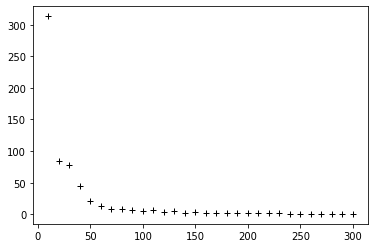

In [60]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (6, 4))
x = np.arange(int(TotalReal_no/10))*10
axes.plot(x[1:31], freqmap_dif[1:31], '+', color='black')

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/frequen map dif vs realization number.png' , dpi=200)

##### (9) Export related data for displaying in Petrel software: groundtruth model, probability data, well data, and generated facies models

###### Groundtruth model

In [61]:
onecube = np.zeros([realcubes_test.shape[4],realcubes_test.shape[2],realcubes_test.shape[3]])
print(onecube.shape)
coords = np.argwhere(onecube>-1)
print(coords.shape)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = realcubes_test.shape[4] - coords[:,0]
coords_output = coords_output.astype(np.int8)

(64, 64, 64)
(262144, 3)


In [62]:
print(synmodel2.shape)
synmodel2_test_output = synmodel2.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1,coords.shape[0]).T.astype(np.int)
synmodel2_test_output = np.where(synmodel2_test_output>0,1,-99)
synmodel2_test_output_txt = np.concatenate((coords_output, synmodel2_test_output), axis = 1)
print(synmodel2_test_output_txt.shape)

(1, 1, 64, 64, 64)
(262144, 4)


In [63]:
synmodel2_test_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/3DRealsynmodel2.txt'
np.savetxt(synmodel2_test_fname , synmodel2_test_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

###### 3D probability data

In [64]:
print(synprob2.shape)
synprob2_plt_output = synprob2.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T
synprob2_plt_output_txt = np.concatenate((coords_output, synprob2_plt_output), axis = 1)
print(synprob2_plt_output_txt.shape)

(1, 1, 64, 64, 64)
(262144, 4)


In [65]:
synprob2_plt_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/3Dsynprob2_64.txt'
np.savetxt(synprob2_plt_fname, synprob2_plt_output_txt, fmt='%i '*3 + "%3.2f ", newline='\n')   # "%03d" + "%.10f"*7

###### 3D well facies data

In [66]:
print(syn_wellfacies_input2_el_onechannel.shape)
syn_wellfacies_input2_el_onechannel_output = syn_wellfacies_input2_el_onechannel.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
syn_wellfacies_input2_el_onechannel_output = np.where(syn_wellfacies_input2_el_onechannel_output <0.5,-99,syn_wellfacies_input2_el_onechannel_output)
syn_wellfacies_input2_el_onechannel_output_txt = np.concatenate((coords_output, syn_wellfacies_input2_el_onechannel_output), axis = 1)
print(syn_wellfacies_input2_el_onechannel_output_txt.shape)

(1, 1, 64, 64, 64)
(262144, 4)


In [67]:
syn_wellfacies_input2_el_onechannel_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/syn2_3DWellFaciesCubes.txt'
np.savetxt(syn_wellfacies_input2_el_onechannel_fname, syn_wellfacies_input2_el_onechannel_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

###### 3D Generated facies models

In [68]:
best30models = condfakemodels[score_ind[-31:-1]]
print(best30models.shape)
best30models_output = best30models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best30models_output = np.where(best30models_output>0,1,-99)
best30models_output_txt = np.concatenate((coords_output, best30models_output), axis = 1)
print(best30models_output_txt.shape)

(30, 1, 64, 64, 64)
(262144, 33)


In [69]:
best30models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/3DCondFakeFaciesModels2_best30_106.txt'
np.savetxt(best30models_fname, best30models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

###### 3D Frequency map calculated from 400 generated facies models

In [70]:
freqmap_output = condfakemodels_freqmap.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T
freqmap_output_txt = np.concatenate((coords_output, freqmap_output), axis = 1)

In [71]:
condfakemodels_freqmap_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model2/3Dfreqmap_106.txt'
np.savetxt(condfakemodels_freqmap_fname, freqmap_output_txt, fmt='%i '*3 + "%3.2f ", newline='\n')   

#### 3.2 Synthetic case 2

##### (1) Get synthetic karst cave model (groundtruth model; i.e., the 12th model in test_set) 

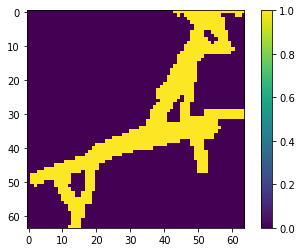

In [72]:
synmodel3 = realcubes_test[12:13]
plt.imshow(synmodel3[0,0,:,:,26])
plt.colorbar()

##### (2) Get probability cube

In [73]:
###### 3D Frequency map calculated from 400 generated facies models

def addnoiseforres64(cube):
    cube_noise = cube
    
    # (1) add noise within cave facies    
    if np.round(np.sum(cube)/200)>0:
        cave_indices = np.argwhere(cube>=0.9)
        cavenoisenumber = np.random.randint(0, np.round(np.sum(cube)/1200))
        cave_noise_indices = np.random.randint(0, cave_indices.shape[0], cavenoisenumber)    
        cave_noise_coos = cave_indices[cave_noise_indices]
        cube_noise[cave_noise_coos[:, 0], cave_noise_coos[:, 1], cave_noise_coos[:, 2]] = (np.random.rand(cavenoisenumber) * 300+10) * (-1)
   
    # (2) add noise within non-cave facies
    noncavenoisenumber = np.random.randint(1, np.round((64*64*64 - np.sum(cube))/8000))
    noncave_indices = np.argwhere(cube<=0.1)
    noncave_noise_indices = np.random.randint(0, noncave_indices.shape[0], noncavenoisenumber)
    noncave_noise_coos = noncave_indices[noncave_noise_indices]
    cube_noise[noncave_noise_coos[:, 0], noncave_noise_coos[:, 1], noncave_noise_coos[:,2]] = np.random.rand(noncavenoisenumber) * 600
    
    return cube_noise

from scipy import ndimage
def calcprobcubeforres64(faciesmodel): #facies model with the dimension of [n, 0, 64, 64, 64]
    probcube = np.zeros((1, 1, 64, 64, 64), dtype=np.float32) 
    k = 6 # kernel size    np.random.choice([4, 6, 8, 10])
    faciesmodel_withnoise = faciesmodel[0,0] #addnoiseforres64(faciesmodel[0,0])
    padvalue = np.mean(faciesmodel_withnoise)
    prob_cube = ndimage.gaussian_filter(faciesmodel_withnoise, (k, k, 2*k), mode = 'constant', cval = padvalue) 
    if np.amax(prob_cube, axis = (0,1,2))<0.25:  # amplify the prob range beyond (0-0.25)
        prob_mx = np.random.rand(1)*0.75+0.25
        prob_cube = (prob_cube - np.amin(prob_cube, axis = (0,1,2))) * prob_mx/(np.amax(prob_cube, axis = (0,1,2)) - np.amin(prob_cube, axis = (0,1,2)))
    prob_cube = np.where(prob_cube>0.9, 0.9, prob_cube)
    prob_cube = np.where(prob_cube<0.02, 0.02, prob_cube) 
    probcube[0, 0] = prob_cube 
    return probcube

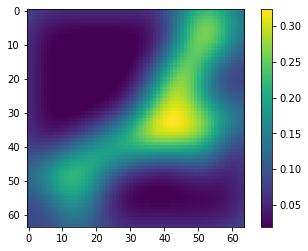

In [74]:
synprob3 = calcprobcubeforres64(synmodel3)
plt.imshow(synprob3[0,0,:,:,45].astype(np.float))
plt.colorbar()

In [75]:
print(np.max(synprob3))

0.5366853


##### (3) Sample well facies from the groundtruth model

In [76]:
def samplewells(cube, cavewellnumber, noncavewellnumber):
    wellfacies = np.ones(cube.shape)*(-99)
    cave_indices = np.argwhere(cube>=0.9)
    cave_wells_indices = np.random.RandomState(59316).randint(0, cave_indices.shape[0], cavewellnumber) 
    cave_wells_coos = cave_indices[cave_wells_indices]
    wellfacies[0,0,cave_wells_coos[:, 2], cave_wells_coos[:, 3], :] = cube[0,0,cave_wells_coos[:, 2], cave_wells_coos[:, 3], :]

    noncave_indices = np.argwhere(cube<=0.1)
    noncave_wells_indices = np.random.RandomState(8038).randint(0, noncave_indices.shape[0], noncavewellnumber) 
    noncave_wells_coos = noncave_indices[noncave_wells_indices]
    wellfacies[0,0,noncave_wells_coos[:, 2], noncave_wells_coos[:, 3], :] = cube[0,0,noncave_wells_coos[:, 2], noncave_wells_coos[:, 3], :]

    return wellfacies

In [77]:
synwellfacies3 = samplewells(synmodel3, 2, 2)

In [78]:
syn_wellpoints3 = np.where(synwellfacies3 == -99, 0, 1)
syn_welltypes3 = np.where(synwellfacies3 == -99, 0, synwellfacies3)
syn_wellfacies_input3 = np.concatenate([syn_wellpoints3, syn_welltypes3], 1)      
print(syn_wellfacies_input3.shape)

(1, 2, 64, 64, 64)


In [79]:
### Enlarge areas of well points into 4 x 4 as inputs

syn_wellfacies_input3 = syn_wellfacies_input3.astype(np.float32)
with tf.device('/gpu:0'):
    syn_wellfacies_input3_enlarge = tf.nn.max_pool3d(syn_wellfacies_input3, ksize = [1,1,4,4,4], strides=[1,1,1,1,1], padding='SAME', data_format='NCDHW') 

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    syn_wellfacies_input3_el = sess.run(syn_wellfacies_input3_enlarge)

# make mask of output well facies data 
syn_wellfacies_input3_el_onechannel = syn_wellfacies_input3_el[:,0:1]+syn_wellfacies_input3_el[:,1:2]
syn_wellfacies_input3_el_onechannel_mask = np.ma.masked_where(syn_wellfacies_input3_el_onechannel == 0, syn_wellfacies_input3_el_onechannel)
cmap_well = plt.cm.viridis  # Can be any colormap that you want after the cm   '.
cmap_well.set_bad(color='white')

In [80]:
print(syn_wellfacies_input3_el.shape)

(1, 2, 64, 64, 64)


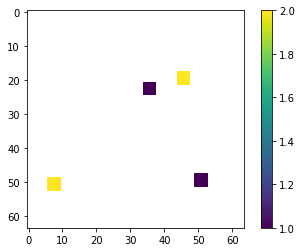

In [81]:
plt.imshow(syn_wellfacies_input3_el_onechannel_mask[0,0,:,:,30])
plt.colorbar()

##### (4) Generate cave models using trained generator

In [82]:
print(synmodel3.shape)
print(synprob3.shape)
print(syn_wellfacies_input3_el.shape)

(1, 1, 64, 64, 64)
(1, 1, 64, 64, 64)
(1, 2, 64, 64, 64)


In [136]:
TotalReal_no = 400
condfakemodels = np.zeros([TotalReal_no, 1, 64, 64, 64])
latents = np.random.randn(TotalReal_no, 8, 4, 4, 4) # .RandomState(215) used in paper
for i in range(int(TotalReal_no/10)):
    latents3 = latents[i*10:(i+1)*10]
    labels3 = np.random.randn(10, 0, 4, 4, 4)  #.RandomState(816)
    syn_wellfacies_input3_el_mult = np.repeat(syn_wellfacies_input3_el, 10, axis=0)
    synprob3_mult = np.repeat(synprob3, 10, axis=0)   
    fakemodels = Gs.run(latents3, labels3, syn_wellfacies_input3_el_mult, synprob3_mult)
    fakemodels = np.where(fakemodels< 0, -1, 1)
    condfakemodels[i*10:(i+1)*10] = fakemodels

In [137]:
print(condfakemodels.shape)

(400, 1, 64, 64, 64)


In [138]:
TotalReal_no = 400
scores = np.zeros(TotalReal_no)
for i in range(int(TotalReal_no/4)):
    scores[i*4:(i+1)*4] = D.run(condfakemodels[i*4:(i+1)*4])[0][:,0]
    
score_ind = np.argsort(scores)

In [139]:
condfakemodels_freqmap = np.expand_dims(np.average((condfakemodels + 1)/2, axis = 0), axis = 0)

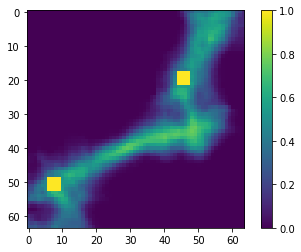

In [140]:
plt.imshow(condfakemodels_freqmap[0,0,:,:,19])
plt.colorbar()

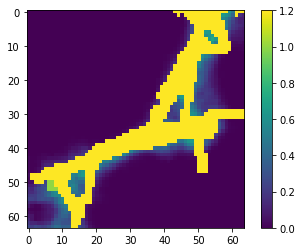

In [141]:
groundtru_overlap_freqmap = np.where(synmodel3 == 1, 1.2, condfakemodels_freqmap)
plt.imshow(groundtru_overlap_freqmap[0,0,:,:,30])
plt.colorbar()

##### (5) Calculate "IOU" distance/similarity between ground truth and generated facies models 

In [142]:
# 1) Calculate cave volume of ground truth facies model (real model)
r_v = np.sum(synmodel3)

# 2) Calculate cave volumes of generated facies models (fake model)
f_v = np.sum(np.where(condfakemodels==1,1,0), axis = (1,2,3,4))

# 3) Calculate cave intersection of groundtruth and generated facies models
i_v = np.sum(np.where((condfakemodels + synmodel3)==2,1,0), axis = (1,2,3,4))

# 4) Calculate IOU (Cave intersection/Cave Union of groundtruth and generated facies models)
IOU = i_v/(r_v + f_v - i_v)

In [143]:
# labels are from -1 to 1
realcubes_test_400, _ = test_set.get_minibatch_cubeandlabel_np(410)  
realcubes_test_400 = realcubes_test_400/255
realcubes_test_400 = realcubes_test_400[10:]

In [144]:
# 2) Calculate cave volumes of generated facies models (fake model)
f_v_test_400 = np.sum(realcubes_test_400, axis = (1,2,3,4))

# 3) Calculate cave intersection of groundtruth and generated facies models
i_v_test_400 = np.sum(np.where((realcubes_test_400 + synmodel3)==2,1,0), axis = (1,2,3,4))

# 4) Calculate IOU (Cave intersection/Cave Union of groundtruth and generated facies models)
IOU_test_400 = i_v_test_400/(r_v + f_v_test_400 - i_v_test_400)

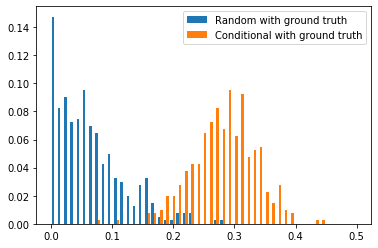

In [145]:
fig, ax = plt.subplots()

w = np.empty(400)
w.fill(1/400)
bins = np.linspace(0, 0.5, 50)

ax.hist([IOU_test_400, IOU], bins, weights=[w, w], label=['Random with ground truth', 'Conditional with ground truth'])
ax.legend(loc='upper right')

save_path = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/IOU histogram.png'
plt.savefig(save_path, dpi=200) 

In [146]:
# Produce facies model realizations as examples when IOU = 0.2

IOU_point2_number = np.argwhere((IOU>0.18) & (IOU<0.22))
scores_point2 = scores[IOU_point2_number]

print(np.concatenate((IOU_point2_number,scores_point2), axis = 1 ))

[[   5.         -194.41917419]
 [  30.         -108.64169312]
 [  34.         -157.28204346]
 [  55.         -295.8354187 ]
 [  58.          -90.17357635]
 [  68.         -237.80825806]
 [  82.         -120.54633331]
 [  89.          -84.31396484]
 [  94.         -199.2727356 ]
 [  97.         -133.56642151]
 [ 100.         -303.69146729]
 [ 104.         -121.08920288]
 [ 106.          -38.01404953]
 [ 107.          -74.47977448]
 [ 111.         -123.27468872]
 [ 115.         -149.76226807]
 [ 131.         -158.54244995]
 [ 156.         -148.72309875]
 [ 161.         -116.14218903]
 [ 175.         -111.19874573]
 [ 187.         -105.03590393]
 [ 197.         -192.85961914]
 [ 199.          -69.12125397]
 [ 223.         -149.71594238]
 [ 228.         -193.90148926]
 [ 241.         -167.5160675 ]
 [ 262.         -120.06278992]
 [ 267.         -146.48712158]
 [ 269.         -162.85372925]
 [ 273.         -183.42623901]
 [ 275.         -295.644104  ]
 [ 324.         -145.34173584]
 [ 328. 

In [147]:
onecube = np.zeros([realcubes_test.shape[4],realcubes_test.shape[2],realcubes_test.shape[3]])
print(onecube.shape)
coords = np.argwhere(onecube>-1)
print(coords.shape)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = realcubes_test.shape[4] - coords[:,0]
coords_output = coords_output.astype(np.int8)

(64, 64, 64)
(262144, 3)


In [148]:
numb = [31, 111, 372, 325]
best4models = condfakemodels[numb]
print(best4models.shape)
best4models_output = best4models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best4models_output = np.where(best4models_output>0,1,-99)
best4models_output_txt = np.concatenate((coords_output, best4models_output), axis = 1)
print(best4models_output_txt.shape)

(4, 1, 64, 64, 64)
(262144, 7)


In [149]:
best4models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/IOU_point2_best4_models.txt'
np.savetxt(best4models_fname, best4models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

In [150]:
# Produce facies model realizations as examples when IOU = 0.3

IOU_point3_number = np.argwhere((IOU>0.295) & (IOU<0.305))
scores_point3 = scores[IOU_point3_number]

print(np.concatenate((IOU_point3_number,scores_point3), axis = 1 ))

[[  21.         -103.35350037]
 [  27.         -248.68814087]
 [  32.         -313.35647583]
 [  33.          -79.14839172]
 [  50.         -163.93505859]
 [  53.         -306.49026489]
 [  79.          -98.75357056]
 [  84.         -289.37356567]
 [ 121.         -129.29672241]
 [ 141.         -254.66418457]
 [ 157.         -266.49130249]
 [ 167.         -145.73588562]
 [ 169.         -174.17903137]
 [ 174.         -145.80105591]
 [ 180.         -208.48509216]
 [ 204.         -186.23391724]
 [ 205.         -153.22387695]
 [ 226.         -290.13446045]
 [ 236.         -184.26734924]
 [ 280.          -93.51039886]
 [ 286.         -203.04881287]
 [ 301.         -161.63287354]
 [ 311.         -121.79019928]
 [ 314.         -201.34208679]
 [ 334.          -92.97667694]
 [ 337.         -180.39610291]
 [ 373.         -123.2199707 ]
 [ 374.         -121.34281921]
 [ 379.         -172.14173889]]


In [151]:
numb = [296,187,140,22]
best4models = condfakemodels[numb]
print(best4models.shape)
best4models_output = best4models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best4models_output = np.where(best4models_output>0,1,-99)
best4models_output_txt = np.concatenate((coords_output, best4models_output), axis = 1)
print(best4models_output_txt.shape)

(4, 1, 64, 64, 64)
(262144, 7)


In [152]:
best4models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/IOU_point3_best4_models.txt'
np.savetxt(best4models_fname, best4models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

In [153]:
# Produce facies model realizations as examples when IOU = 0.4

IOU_point4_number = np.argwhere((IOU>0.37) & (IOU<0.43))
scores_point4 = scores[IOU_point4_number]

print(np.concatenate((IOU_point4_number,scores_point4), axis = 1 ))

[[   2.         -195.38638306]
 [   3.         -209.40197754]
 [   9.         -202.74369812]
 [  26.         -147.03109741]
 [  41.         -275.62985229]
 [  96.         -257.759552  ]
 [ 133.         -236.98399353]
 [ 144.          -89.67063904]
 [ 168.         -204.77388   ]
 [ 191.         -134.23738098]
 [ 213.         -196.79649353]
 [ 229.          -96.17168427]
 [ 243.         -287.2225647 ]
 [ 281.         -136.61660767]
 [ 341.         -152.54405212]
 [ 342.         -274.93902588]
 [ 380.         -277.85714722]]


In [154]:
numb = [73, 147, 54, 299]
best4models = condfakemodels[numb]
print(best4models.shape)
best4models_output = best4models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best4models_output = np.where(best4models_output>0,1,-99)
best4models_output_txt = np.concatenate((coords_output, best4models_output), axis = 1)
print(best4models_output_txt.shape)

(4, 1, 64, 64, 64)
(262144, 7)


In [155]:
best4models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/IOU_point4_best4_models.txt'
np.savetxt(best4models_fname, best4models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

##### (6) Make Multiscale-pyramid-sliced Wasserstein based MDS plot

In [156]:
def pyr_down(model): # matches cv2.pyrDown()
    assert model.ndim == 4
    return np.expand_dims(scipy.ndimage.gaussian_filter(model[0], (2, 2, 2), mode='mirror')[::2,::2, ::2], axis = 0)

def pyr_up(minibatch): # matches cv2.pyrUp()
    assert minibatch.ndim == 4
    S = minibatch.shape
    res = np.zeros((S[0], S[1] * 2, S[2] * 2, S[3] * 2), minibatch.dtype)
    res[:, ::2, ::2, ::2] = minibatch
    return np.expand_dims(scipy.ndimage.gaussian_filter(res[0], (2, 2, 2), mode='mirror') * 8, axis = 0) 

def generate_laplacian_pyramid(model, num_levels):  # model with shape of [1,64,64,64],num_levels = 3
    pyramid = [np.float32(model)]
    for i in range(1, num_levels):
        pyramid.append(pyr_down(pyramid[-1]))
        pyramid[-2] -= pyr_up(pyramid[-1])
    return pyramid

def get_descriptors_for_minibatch(minibatch, nhood_size, nhoods_per_image):
    S = minibatch.shape # (minibatch, length, width, height)  [1, 64, 64, 64]
    assert len(S) == 4 
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, x, y, z = np.ogrid[0:N,-H:H+1, -H:H+1, -H:H+1]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[1] - H, size=(N, 1, 1, 1))
    y = y + np.random.randint(H, S[2] - H, size=(N, 1, 1, 1))
    z = z + np.random.randint(H, S[3] - H, size=(N, 1, 1, 1))
    idx = ((img * S[1] + x) * S[2] + y) * S[3] + z
    return minibatch.flat[idx]

def finalize_descriptors(desc):
    if isinstance(desc, list):
        desc = np.concatenate(desc, axis=0)
    assert desc.ndim == 4 # (neighborhood, length, width, height)
    desc -= np.mean(desc, axis=(0, 1, 2, 3), keepdims=True)
    desc /= np.std(desc, axis=(0, 1, 2, 3), keepdims=True)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def sliced_wasserstein(A, B, dir_repeats, dirs_per_repeat):
    assert A.ndim == 2 and A.shape == B.shape                           # (neighborhood, descriptor_component)
    results = []
    for repeat in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)             # (descriptor_component, direction)
        dirs /= np.sqrt(np.sum(np.square(dirs), axis=0, keepdims=True)) # normalize descriptor components for each direction
        dirs = dirs.astype(np.float32)
        projA = np.matmul(A, dirs)                                      # (neighborhood, direction)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)                                  # sort neighborhood projections for each direction
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)                                   # pointwise wasserstein distances
        results.append(np.mean(dists))                                  # average over neighborhoods and directions
    return np.mean(results)                                             # average over repeats

In [157]:
# realcubes_test_400:  400 test facies models,  (400, 1, 64, 64, 64), 0 to 1
# condfakemodels:  400 produced conditional facies models,  (400, 1, 64, 64, 64), -1 to 1
# synmodel2:  original test ground truth facies model,  (1, 1, 64, 64, 64), 0 to 1

from scipy import signal
from scipy.ndimage.filters import convolve
from sklearn import manifold
from matplotlib import pyplot as plt
from scipy.stats import kde
import scipy.ndimage

# MDS map for 200 test facies models, 50 produced facies models, and 1 ground truth facies models orderly
test_mds_num = 100
prod_mds_num = 40
testmodels_mds = realcubes_test_400[300:300+test_mds_num]
prodmodels_mds = (condfakemodels[score_ind[-(prod_mds_num+1):-1]]+1)/2
allmodels_mds = np.squeeze(np.concatenate((testmodels_mds, prodmodels_mds,synmodel3), axis = 0))  # shape [251, 64, 64, 64]

nhood_size         = 5   # neighborhood size, 5x5x5
nhoods_per_cube   = 24   
dir_repeats        = 4
dirs_per_repeat    = 32
resolutions = [64, 32, 16]  # pyramid resolutions 

groups_lap = []
for i in range(test_mds_num+prod_mds_num+1):
    descriptors = [[] for res in resolutions]
    for lod, level in enumerate(generate_laplacian_pyramid(allmodels_mds[i:i+1], len(resolutions))):
        desc = get_descriptors_for_minibatch(level, nhood_size, nhoods_per_cube)
        descriptors[lod].append(desc)
    groups_lap.append(descriptors)

In [158]:
kk = np.tril(np.ones((test_mds_num+prod_mds_num+1,test_mds_num+prod_mds_num+1)), -1)  
coor = np.argwhere(kk > 0)
list_1 = coor[:, 0]
list_2 = coor[:, 1]  
        
gr_swd = []
for gr in range(list_1.shape[0]):
    desc_1 = [finalize_descriptors(d) for d in groups_lap[list_1[gr]]]
    desc_2 = [finalize_descriptors(d) for d in groups_lap[list_2[gr]]]
    slw = [sliced_wasserstein(dreal, dfake, dir_repeats, dirs_per_repeat) for dreal, dfake in zip(desc_1, desc_2)]
    gr_swd.append(np.mean(slw))
        
def convert_to_matrix(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1) # or np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n),dtype=float)
    out[mask] = a
    np.transpose(out)[mask] = a        
    return out        

swd_matrix = convert_to_matrix(gr_swd)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The following kwargs were not used by contour: 'label'
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: The following kwargs were not used by contour: 'label'


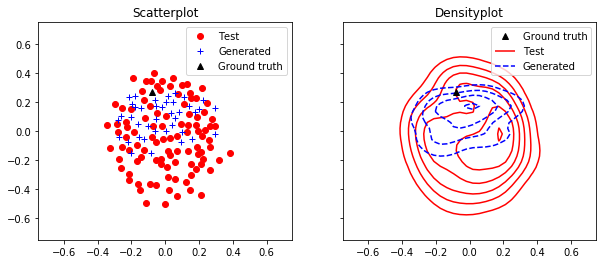

In [164]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
coos = mds.fit(swd_matrix).embedding_
        
x_test_co = coos[:test_mds_num, 0]
y_test_co = coos[:test_mds_num, 1]
x_produced_co = coos[test_mds_num:test_mds_num+prod_mds_num, 0]
y_produced_co = coos[test_mds_num:test_mds_num+prod_mds_num, 1]  
x_groundtruth_co = coos[test_mds_num+prod_mds_num:, 0]
y_groundtruth_co = coos[test_mds_num+prod_mds_num:, 1] 
        
plot_lim_min = -0.75
plot_lim_max = 0.75

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, sharey='row')
fig.set_size_inches(10, 4, forward=True)
        
axes[0].set_title('Scatterplot')
axes[0].set_xlim([plot_lim_min, plot_lim_max])
axes[0].set_ylim([plot_lim_min, plot_lim_max])        
axes[0].plot(x_test_co, y_test_co, 'ro', label = 'Test')
axes[0].plot(x_produced_co, y_produced_co, 'b+', label = 'Generated')
axes[0].plot(x_groundtruth_co, y_groundtruth_co, 'k^', label = 'Ground truth')
axes[0].legend(loc='upper right')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 40
k_test = kde.gaussian_kde((coos.T[:, :test_mds_num]))
xi_test, yi_test = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_test = k_test(np.vstack([xi_test.flatten(), yi_test.flatten()]))
axes[1].set_xlim([plot_lim_min, plot_lim_max])
axes[1].set_ylim([plot_lim_min, plot_lim_max])                
test_contr = axes[1].contour(xi_test, yi_test, zi_test.reshape(xi_test.shape), 6, colors='r', label = 'Test') 

k_produced = kde.gaussian_kde((coos.T[:, test_mds_num:test_mds_num+prod_mds_num]))
xi_produced, yi_produced = np.mgrid[plot_lim_min:plot_lim_max:nbins*1j, plot_lim_min:plot_lim_max:nbins*1j]
zi_produced = k_produced(np.vstack([xi_produced.flatten(), yi_produced.flatten()]))
produced_contr = axes[1].contour(xi_produced, yi_produced, zi_produced.reshape(xi_produced.shape), 5, colors='blue',  linestyles= 'dashed', label = 'Generated') 
        
test_contr.collections[0].set_label('Test')
produced_contr.collections[0].set_label('Generated')

axes[1].plot(x_groundtruth_co, y_groundtruth_co, 'k^', label = 'Ground truth')
        
axes[1].set_title('Densityplot')

axes[1].legend(loc='upper right') 
        
plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/features_MDS_plot.png' , dpi=200)


##### (7) Make input probabilitymap-frequency map-ground truth comparison plot

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'label'
  from ipykernel import kernelapp as app
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'label'


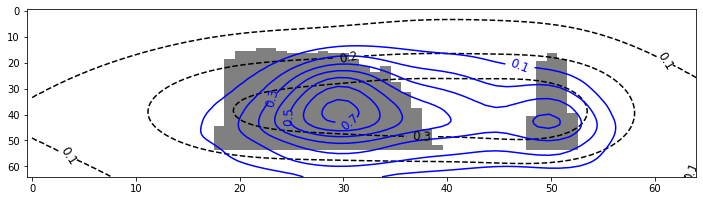

In [107]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl 

# at y = 40

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (12,10))

y, x = np.mgrid[0:64:64j, 0:64:64j]

synmodel3_plt = synmodel3[0,0,40,:,:]
colors = ['white', 'grey'] 
cmap = mpl.colors.ListedColormap(colors)
axes.imshow(synmodel3_plt.transpose(1,0)[::-1,:], cmap = cmap, aspect = 0.25)

inprob_contr = axes.contour(y, x, synprob3[0,0,40,:,::-1], [0.1, 0.2, 0.3, 0.4], colors='k', linestyles= 'dashed', label = 'Probability map contour') 
plt.clabel(inprob_contr,fmt='%1.1f', inline=True, fontsize=12)

z = gaussian_filter(condfakemodels_freqmap[0,0,40,:,::-1], sigma = 2.5)
freq_contr = axes.contour(y, x, z, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='blue', label = 'Frequency map contour') 
plt.clabel(freq_contr,[0.1,0.3, 0.5, 0.7], fmt='%1.1f', inline=True, fontsize=12)

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/Prob_freq_Compar_y40.png' , dpi=200)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  app.launch_new_instance()


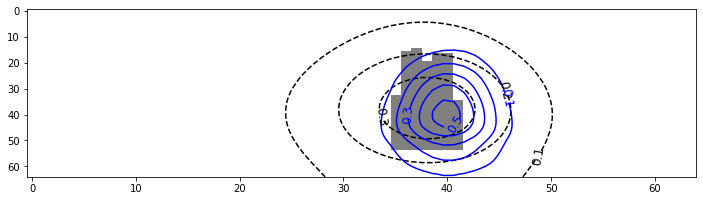

In [108]:
# at x =30

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (12,10))

y, x = np.mgrid[0:64:64j, 0:64:64j]

synmodel3_plt = synmodel3[0,0,:,30,:]
colors = ['white', 'grey'] 
cmap = mpl.colors.ListedColormap(colors)
axes.imshow(synmodel3_plt.transpose(1,0)[::-1,:], cmap = cmap, aspect = 0.25)

inprob_contr = axes.contour(y, x, synprob3[0,0,:,30,::-1], [0.1, 0.2, 0.3, 0.4], colors='k', linestyles= 'dashed', label = 'Probability map contour') 
plt.clabel(inprob_contr,fmt='%1.1f', inline=True, fontsize=12)

z = gaussian_filter(condfakemodels_freqmap[0,0,:,30,::-1], sigma = 2.5)
freq_contr = axes.contour(y, x, z, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='blue', label = 'Frequency map contour') 
plt.clabel(freq_contr,[0.1,0.3, 0.5, 0.7], fmt='%1.1f', inline=True, fontsize=12)

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/Prob_freq_Compar_x30.png' , dpi=200)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  app.launch_new_instance()


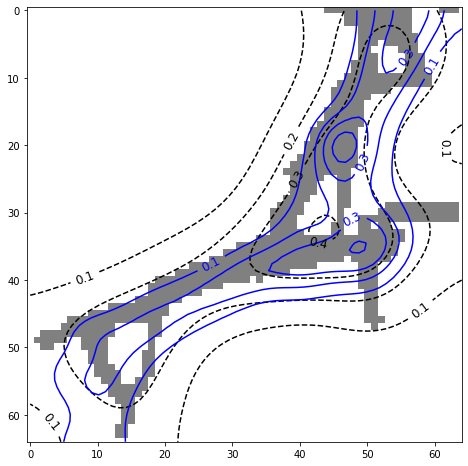

In [109]:
# at z =40

fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (8,8))

y, x = np.mgrid[0:64:64j, 0:64:64j]

synmodel3_plt = synmodel3[0,0,:,:,40]
colors = ['white', 'grey'] 
cmap = mpl.colors.ListedColormap(colors)
axes.imshow(synmodel3_plt, cmap = cmap, aspect = 1)

inprob_contr = axes.contour(x, y, synprob3[0,0,:,:,40], [0.1, 0.2, 0.3, 0.4], colors='k', linestyles= 'dashed', label = 'Probability map contour') 
plt.clabel(inprob_contr,fmt='%1.1f', inline=True, fontsize=12)

z = gaussian_filter(condfakemodels_freqmap[0,0,:,:,40], sigma = 2.5)
freq_contr = axes.contour(x, y, z, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='blue', label = 'Frequency map contour') 
plt.clabel(freq_contr,[0.1,0.3, 0.5, 0.7], fmt='%1.1f', inline=True, fontsize=12)

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/Prob_freq_Compar_z40.png' , dpi=200)

##### (8) Plot the change of frequency map with the number of produced facies models

In [110]:
TotalReal_no = 1000
condfakemodels = np.zeros([TotalReal_no, 1, 64, 64, 64])
latents = np.random.RandomState(79315).randn(TotalReal_no, 8, 4, 4, 4)
freqmap_cur = np.zeros([1, 1, 64, 64, 64])
freqmap_dif = np.zeros([int(TotalReal_no/10)])
for i in range(int(TotalReal_no/10)):
    latents3 = latents[i*10:(i+1)*10]
    labels3 = np.random.randn(10, 0, 4, 4, 4)  #.RandomState(816)
    syn_wellfacies_input3_el_mult = np.repeat(syn_wellfacies_input3_el, 10, axis=0)
    synprob3_mult = np.repeat(synprob3, 10, axis=0)   
    fakemodels = Gs.run(latents3, labels3, syn_wellfacies_input3_el_mult, synprob3_mult)
    fakemodels = np.where(fakemodels< 0, -1, 1)
    condfakemodels[i*10:(i+1)*10] = fakemodels
    freqmap_new = np.expand_dims(np.average((condfakemodels[:(i+1)*10] + 1)/2, axis = 0), axis = 0)
    freqmap_dif[i] = np.sum((freqmap_new - freqmap_cur)**2)
    freqmap_cur = freqmap_new

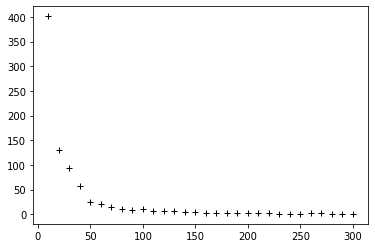

In [111]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize = (6, 4))
x = np.arange(int(TotalReal_no/10))*10
axes.plot(x[1:31], freqmap_dif[1:31], '+', color='black')

plt.savefig('/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/frequen map dif vs realization number.png' , dpi=200)

##### (9) Export related data for displaying in Petrel software: groundtruth model, probability data, well data, and generated facies models 

###### Groundtruth model

In [112]:
onecube = np.zeros([realcubes_test.shape[4],realcubes_test.shape[2],realcubes_test.shape[3]])
print(onecube.shape)
coords = np.argwhere(onecube>-1)
print(coords.shape)
coords_output = np.zeros(coords.shape)
coords_output[:,0] = coords[:,2]+1
coords_output[:,1] = coords[:,1]+1
coords_output[:,2] = realcubes_test.shape[4] - coords[:,0]
coords_output = coords_output.astype(np.int8)

(64, 64, 64)
(262144, 3)


In [113]:
print(synmodel3.shape)
synmodel3_test_output = synmodel3.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1,coords.shape[0]).T.astype(np.int)
synmodel3_test_output = np.where(synmodel3_test_output>0,1,-99)
synmodel3_test_output_txt = np.concatenate((coords_output, synmodel3_test_output), axis = 1)
print(synmodel3_test_output_txt.shape)

(1, 1, 64, 64, 64)
(262144, 4)


In [114]:
synmodel3_test_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/3DRealsynmodel3.txt'
np.savetxt(synmodel3_test_fname , synmodel3_test_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

###### 3D probability data

In [115]:
print(synprob3.shape)
synprob3_plt_output = synprob3.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T
synprob3_plt_output_txt = np.concatenate((coords_output, synprob3_plt_output), axis = 1)
print(synprob3_plt_output_txt.shape)

(1, 1, 64, 64, 64)
(262144, 4)


In [116]:
synprob3_plt_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/3Dsynprob3_64.txt'
np.savetxt(synprob3_plt_fname, synprob3_plt_output_txt, fmt='%i '*3 + "%3.2f ", newline='\n')   # "%03d" + "%.10f"*7

###### 3D well facies data

In [117]:
print(syn_wellfacies_input3_el_onechannel.shape)
syn_wellfacies_input3_el_onechannel_output = syn_wellfacies_input3_el_onechannel.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
syn_wellfacies_input3_el_onechannel_output = np.where(syn_wellfacies_input3_el_onechannel_output <0.5,-99,syn_wellfacies_input3_el_onechannel_output)
syn_wellfacies_input3_el_onechannel_output_txt = np.concatenate((coords_output, syn_wellfacies_input3_el_onechannel_output), axis = 1)
print(syn_wellfacies_input3_el_onechannel_output_txt.shape)

(1, 1, 64, 64, 64)
(262144, 4)


In [118]:
syn_wellfacies_input3_el_onechannel_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/syn3_3DWellFaciesCubes.txt'
np.savetxt(syn_wellfacies_input3_el_onechannel_fname, syn_wellfacies_input3_el_onechannel_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

###### 3D Generated facies models

In [119]:
best30models = condfakemodels[score_ind[-31:-1]]
print(best30models.shape)
best30models_output = best30models.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T.astype(np.int)
best30models_output = np.where(best30models_output>0,1,-99)
best30models_output_txt = np.concatenate((coords_output, best30models_output), axis = 1)
print(best30models_output_txt.shape)

(30, 1, 64, 64, 64)
(262144, 33)


In [120]:
best30models_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/3DCondFakeFaciesModels3_best30_106.txt'
np.savetxt(best30models_fname, best30models_output_txt, fmt='%i', newline='\n')   # "%03d" + "%.10f"*7

###### 3D Frequency map calculated from 400 generated facies models

In [121]:
freqmap_output = condfakemodels_freqmap.transpose(0,1,4,2,3)[:,:,:,::-1,:].reshape(-1, coords.shape[0]).T
freqmap_output_txt = np.concatenate((coords_output, freqmap_output), axis = 1)

In [122]:
condfakemodels_freqmap_fname = '/scratch/users/suihong/CaveSimulation/GANTrainingResults/64Cube Synthetic Model3/3Dfreqmap_106.txt'
np.savetxt(condfakemodels_freqmap_fname, freqmap_output_txt, fmt='%i '*3 + "%3.2f ", newline='\n')   

## 4. Evaluation of Generator's conditioning ability to input well data

In [123]:
latents_plt = np.random.RandomState(816).randn(10, 8, 4, 4, 4)
labels_plt = np.random.RandomState(816).randn(10, 0, 4, 4, 4)
probcubes_plt = probcubes_test

wellfaciescubes_plt = np.concatenate([np.where(wellfaciescubes_test>0, 1, 0), np.where(wellfaciescubes_test<1.5, 0, 1)], 1)
print(wellfaciescubes_plt.shape)

(30, 2, 64, 64, 64)


In [124]:
condfakecubes_plt = Gs.run(latents_plt, labels_plt, wellfaciescubes_plt, probcubes_plt)
condfakecubes_plt = np.where(condfakecubes_plt< 0, -1, 1)

In [125]:
def well_points_accuracy(well_facies_a, fake_imgs_a):
    gg = well_facies_a[:,0:1] + well_facies_a[:,1:2]
    
    recognized_f1 = np.where((gg==2) & (well_facies_a[:,0:1] * (fake_imgs_a+1) > 0.8), 1, 0)
    f1_prob = np.sum(recognized_f1)/np.sum(np.where(gg==2,1,0))

    recognized_f0 = np.where((gg==1) & (well_facies_a[:,0:1] * (fake_imgs_a+2) ==1), 1, 0)
    f0_prob = np.sum(recognized_f0)/np.sum(np.where(gg==1,1,0))
    
    return f1_prob, f0_prob

In [126]:

f_c_prob, f_m_prob = well_points_accuracy(wellfaciescubes_plt, condfakecubes_plt)
print(f_c_prob)
print(f_m_prob)

ValueError: operands could not be broadcast together with shapes (30,1,64,64,64) (10,1,64,64,64) 